In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-dataset/FashionDataset.csv


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
df = pd.read_csv("/kaggle/input/e-commerce-dataset/FashionDataset.csv")
df.head()

,Unnamed: 0,BrandName,Deatils,Sizes,MRP,SellPrice,Discount,Category
0,0,life,solid cotton blend collar neck womens a-line d...,"Size:Large,Medium,Small,X-Large,X-Small",Rs\n1699,849,50% off,Westernwear-Women
1,1,only,polyester peter pan collar womens blouson dres...,"Size:34,36,38,40",Rs\n3499,2449,30% off,Westernwear-Women
2,2,fratini,solid polyester blend wide neck womens regular...,"Size:Large,X-Large,XX-Large",Rs\n1199,599,50% off,Westernwear-Women
3,3,zink london,stripes polyester sweetheart neck womens dress...,"Size:Large,Medium,Small,X-Large",Rs\n2299,1379,40% off,Westernwear-Women
4,4,life,regular fit regular length denim womens jeans ...,"Size:26,28,30,32,34,36",Rs\n1699,849,50% off,Westernwear-Women


In [4]:
print("Exploring the d_set  : \n")
print("Information of the dataset :\n", df.info(),"\n")
print("Shape of the dataset: \n",df.shape ,"\n")
print("Description :\n",df.describe(),"\n")
print("Data type of each column :\n",df.dtypes,"\n")
print("Head of the dataset :\n",df.head(5),"\n")
print("Tail of the dataset :\n",df.tail(5),"\n")
print("Some random sample :\n",df.sample(15),"\n")

Exploring the d_set  : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30758 entries, 0 to 30757
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30758 non-null  int64 
 1   BrandName   30758 non-null  object
 2   Deatils     30758 non-null  object
 3   Sizes       30758 non-null  object
 4   MRP         30758 non-null  object
 5   SellPrice   30758 non-null  object
 6   Discount    30758 non-null  object
 7   Category    30758 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.9+ MB
Information of the dataset :
 None 

Shape of the dataset: 
 (30758, 8) 

Description :
          Unnamed: 0
count  30758.000000
mean      12.500000
std        7.500122
min        0.000000
25%        6.000000
50%       12.500000
75%       19.000000
max       25.000000 

Data type of each column :
 Unnamed: 0     int64
BrandName     object
Deatils       object
Sizes         object
MRP           object
SellPrice    

In [5]:
#metadata
df.columns.tolist() 

['Unnamed: 0',
 'BrandName',
 'Deatils',
 'Sizes',
 'MRP',
 'SellPrice',
 'Discount',
 'Category']

**Cleaning and preprocessing**

In [6]:
df.isnull().sum()   

Unnamed: 0    0
BrandName     0
Deatils       0
Sizes         0
MRP           0
SellPrice     0
Discount      0
Category      0
dtype: int64

In [7]:
df1 = df.drop_duplicates()
df1.shape

(29427, 8)

In [8]:
df["Sizes"] = df["Sizes"].str.replace("Size:","",regex=True)
df["Sizes"] = df["Sizes"].str.split(",").astype(str)

In [9]:
df["MRP"]=df["MRP"].astype(str).str.replace("Rs\n",  "").astype(float)
df["SellPrice"] = df["SellPrice"].astype(float)

df["Discount"] = df["Discount"].astype(str).str.replace("% off",  "").astype(float)/100
df["Category"] = df["Category"].str.replace("-Women","").astype("category")

df["Deatils"] = df["Deatils"].astype("string")
df["BrandName"] = df["BrandName"].astype(str)

In [10]:
df = df.drop("Unnamed: 0",axis="columns")

In [11]:
df.sample(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,BrandName,Deatils,Sizes,MRP,SellPrice,Discount,Category
6421,emblaze,solid off shoulder viscose womens regular dres...,"['Large', 'Medium', 'Small', 'X-Large', 'X-Sma...",NaN,3000.0,NaN,Westernwear
17982,w,solid regular length net woven womens dupatta ...,['Nan'],NaN,1199.0,NaN,Indianwear
29191,michael kors,womens premium rose gold earring - mkc1299an791,['Nan'],6495.0,2598.0,0.60,Jewellery
26590,monrow,rubber slip on womens casual slip ons - pink,"['38', '39']",1899.0,892.0,0.53,Footwear
1706,kraus,mom fit ankle length cotton womens jeans - dar...,"['28', '30', '32', '34', '36']",1895.0,1705.0,0.10,Westernwear
27028,fastrack,unisex analogue plastic watch,['Nan'],NaN,1195.0,NaN,Watches
16223,global desi,self design key hole neck womens kurta - black,"['XL', 'Large', 'Medium', 'Small', 'X-Small']",2599.0,1689.0,0.35,Indianwear
18448,ziyaa,printed round neck rayon womens ethnic set - blue,"['Large', 'Medium', 'Small', 'X-Large', 'XX-La...",3013.0,1205.0,0.60,Indianwear
10238,faballey,stripes georgette womens regular top - red,['Small'],1700.0,850.0,0.50,Westernwear
11627,infuse,printed round neck rayon womens regular dress ...,"['Large', 'Medium', 'Small', 'X-Large', 'X-Sma...",1599.0,479.0,0.70,Indianwear


In [12]:
df = df.dropna(subset=["MRP"])
'''After dropping Nan values from MRP the Nan values from Sellprice and Discount also removed because 
They were related'''

'After dropping Nan values from MRP the Nan values from Sellprice and Discount also removed because \nThey were related'

In [13]:
df.sample(10)

,BrandName,Deatils,Sizes,MRP,SellPrice,Discount,Category
8851,dolce crudo,womens regular fit i'm sinking under denim top...,['X-Small'],2299.0,1034.0,0.55,Westernwear
15770,vastranand,embellished zari polyester blend festive wear ...,['Nan'],5500.0,3300.0,0.40,Indianwear
6543,crimsoune club,checks cotton collared womens shirt - multi,"['Large', 'Medium', 'Small', 'X-Large', 'XX-La...",1399.0,1259.0,0.10,Westernwear
18907,global desi,geometric viscose key hole neck womens knee le...,"['Large', 'Medium', 'Small', 'X-Small']",1999.0,999.0,0.50,Indianwear
6274,zink london,solid polyester v neck womens casual wear shru...,['Large'],2299.0,919.0,0.60,Westernwear
5041,kraus,stripes cotton collar neck womens crop shirt -...,"['Large', 'Medium', 'Small', 'X-Small']",1199.0,839.0,0.30,Westernwear
2933,sera,solid round neck cotton womens bodycon dress -...,"['Large', 'Medium', 'Small']",1694.0,762.0,0.55,Westernwear
23423,wacoal,wired fixed straps lightly padded womens every...,"['34-C', '36-E', '38-DD', '40-D', '40-DD', '40...",3495.0,1747.0,0.50,Lingerie&Nightwear
21913,erotissch,nylon low rise womens hipster briefs - pale pink,"['Large', 'Medium', 'Small', 'X-Large']",499.0,224.0,0.55,Lingerie&Nightwear
7621,zink london,regular fit mid thigh polyester womens casual ...,"['Large', 'Medium', 'Small', 'X-Large']",1599.0,1279.0,0.20,Westernwear


In [14]:
def unique_data_count(df):
    print("*************************************")
    print("Number of unique data in each column :")
    print("*************************************")
    print("Brandname :",df.BrandName.nunique(),"\n")
    print("Details: ",df.Deatils.nunique(),"\n")
    print("Sizes :",df.Sizes.nunique(),"\n")
    print("Category :",df.Category.nunique(),"\n")
unique_data_count(df)

*************************************
Number of unique data in each column :
*************************************
Brandname : 177 

Details:  18210 

Sizes : 937 

Category : 7 



In [15]:
df.rename(columns={'Deatils': 'Details'}, inplace=True)

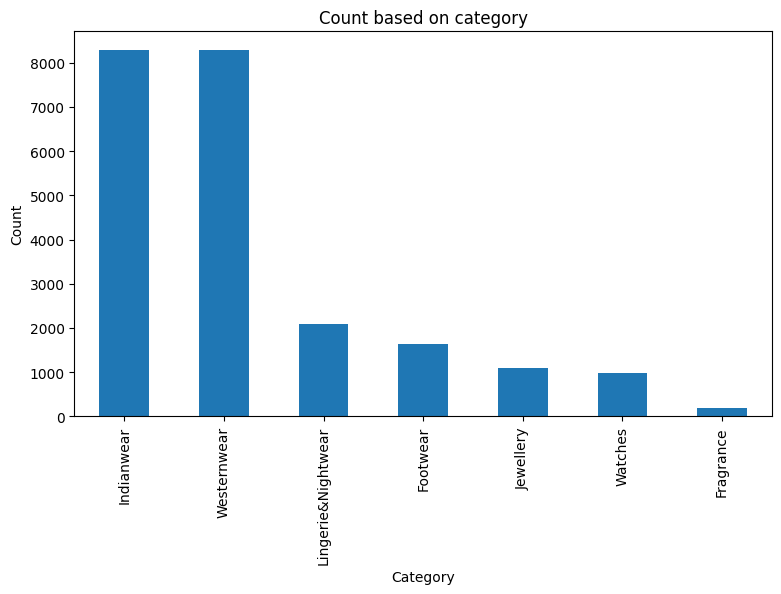

In [16]:
df["Category"].value_counts().plot(kind="bar",figsize=(9, 5))
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Count based on category")
plt.show()

count    22550.000000
mean      1472.929268
std       1567.185295
min         74.000000
25%        699.000000
50%       1079.000000
75%       1749.000000
max      23996.000000
Name: SellPrice, dtype: float64


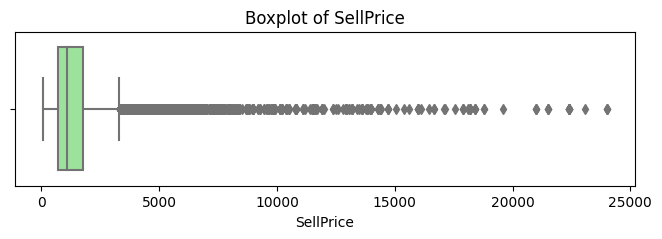

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


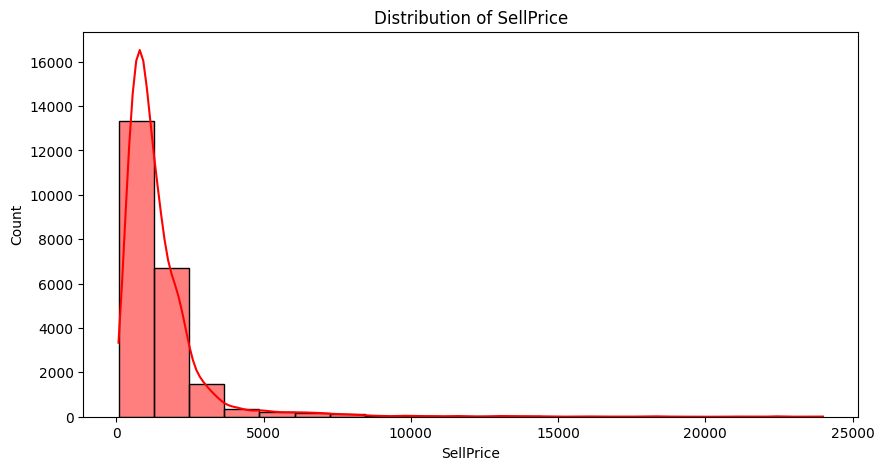

**********************
Skewness and Kurtosis
**********************
Skewness: 5.481861500866623
Kurtosis: 47.90627468748717


In [17]:
from scipy.stats import skew, kurtosis
def Sellprice_analysis(df):
    print(df["SellPrice"].describe())

    #looking for Distribution of the data 
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df["SellPrice"], color="lightgreen")
    plt.title("Boxplot of SellPrice")
    plt.xlabel("SellPrice")
    plt.show()

    #Boxplot to spot outliers
    plt.figure(figsize=(10, 5))
    sns.histplot(df["SellPrice"], bins=20, kde=True, color="red")
    plt.title("Distribution of SellPrice")
    plt.xlabel("SellPrice")
    plt.ylabel("Count")
    plt.show()

    #Numerical sense of distribution
    print("**********************")
    print("Skewness and Kurtosis")
    print("**********************")
    print("Skewness:", skew(df["SellPrice"].dropna()))
    print("Kurtosis:", kurtosis(df["SellPrice"].dropna()))
    

Sellprice_analysis(df)

In [18]:
Q1 = df["SellPrice"].quantile(0.25)
Q3 = df["SellPrice"].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["SellPrice"] >= lower_bound) & (df["SellPrice"] <= upper_bound)]


print("********************************************")
print("Skewness and kurtosis after outlier removal ")
print("********************************************")
print("Skewness:", skew(df["SellPrice"].dropna()))
print("Kurtosis:", kurtosis(df["SellPrice"].dropna()))


********************************************
Skewness and kurtosis after outlier removal 
********************************************
Skewness: 0.8394042330122989
Kurtosis: 0.11585223381315757


In [19]:
#Brand with less than 5 products will be treated as other from now 
df["BrandName"].nunique()
brand_counts = df["BrandName"].value_counts()
rare_brands = brand_counts[brand_counts < 5].index
df["BrandName"] = df["BrandName"].apply(lambda x: "Other" if x in rare_brands else x)
df.shape

(21283, 7)

In [20]:
# Duplicates
print("Duplicate Rows:", df.duplicated().sum())


#Negative or zero  values 
for col in df.select_dtypes(include=["float64","int64"]).columns:
    if(df[col] <= 0).any():
        print(f"Warning The data in {col} is zero or negative ")

# Categorical inconsistncies
for col in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in {col}:", df[col].unique())


Duplicate Rows: 1347
Warning The data in Discount is zero or negative 
Unique values in BrandName: ['life' 'only' 'fratini' 'zink london' 'kraus' 'rare' 'van heusen' 'stop'
 'cover story' 'infuse' 'allen solly' 'altlife' 'madame' 'iti' 'and'
 'faballey' 'latin quarters' 'sera' 'adidas' 'pepe' 'indya' 'juniper'
 'lovegen' 'forever new' 'magre' 'insense' 'Other' 'reebok' 'marie claire'
 'enamor' 'vero moda' 'spykar' 'dolce crudo' 'global desi'
 'crimsoune club' 'haute curry' 'proline' 'puma' 'myshka' '109f' 'w'
 'gipsy' 'samshek' 'is.u' 'kami kubi' 'varanga' 'de moza' 'janasya'
 'kashish' 'ayesha' 'erotissch' 'biba' 'mystere paris' 'soie'
 'sweet dreams' 'yuris' 'suti' 'sanaa' 'ziyaa' 'jack and jones' 'aurelia'
 'shaya by caratlane' 'neerus' 'amukti' 'vastranand' 'varkala silk sarees'
 'fusion beats' 'emporio armani' 'united colors of benetton' 'clovia'
 'triumph' 'amante' 'parfait' 'wacoal' 'catwalk' 'inc.5' 'estatos'
 'tresmode' 'lemon & pepper' 'shoetopia' 'skechers' 'ceriz' 'clarks'


Target Distribution:
SellPrice
499.0     0.027205
999.0     0.025325
599.0     0.024856
899.0     0.023305
749.0     0.022553
            ...   
1613.0    0.000047
698.0     0.000047
2418.0    0.000047
1301.0    0.000047
643.0     0.000047
Name: proportion, Length: 1221, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


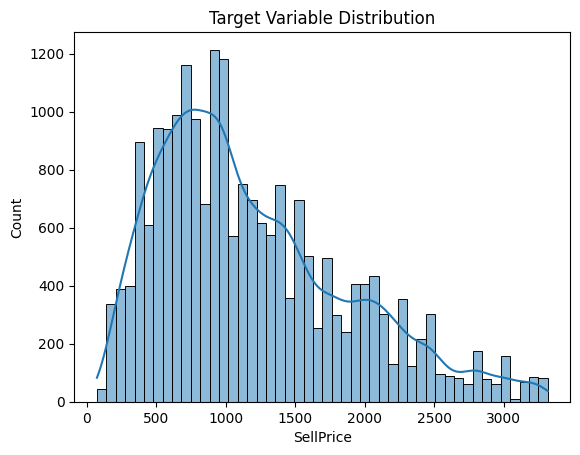

In [21]:
# Classification: Check class imbalance
print("Target Distribution:")
print(df['SellPrice'].value_counts(normalize=True))

# Regression: target distribution
if df['SellPrice'].dtype in ['float64', 'int64']:
    sns.histplot(df['SellPrice'], kde=True)
    plt.title("Target Variable Distribution")
    plt.show()


In [22]:
from scipy.stats import f_oneway, chi2_contingency

# ANOVA--> numerical features vs target (classification)
anova_results = {}
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col != 'SellPrice':
        groups = [group[col].dropna() for name, group in df.groupby('SellPrice')]
        if len(groups) > 1:
            stat, p = f_oneway(*groups)
            anova_results[col] = p
anova_results = {k: v for k, v in anova_results.items() if v < 0.05}
print("Significant features based on ANOVA (p < 0.05):", anova_results)

# Chi-squared--> categorical features vs target
for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != 'SellPrice':
        contingency = pd.crosstab(df[col], df['SellPrice'])
        chi2, p, dof, ex = chi2_contingency(contingency)
        print(f"Chi-square test for {col} vs target: p-value = {p:.4f}")


Significant features based on ANOVA (p < 0.05): {'MRP': 0.0, 'Discount': 0.0}
Chi-square test for BrandName vs target: p-value = 0.0000
Chi-square test for Sizes vs target: p-value = 0.0000
Chi-square test for Category vs target: p-value = 0.0000


In [23]:
df.sample(10)

,BrandName,Details,Sizes,MRP,SellPrice,Discount,Category
19492,vastranand,printed zari linen festive wear womens regular...,['Nan'],3475.0,1563.0,0.55,Indianwear
28514,Other,men deodorant spray 200 ml,['Nan'],995.0,895.0,0.10,Fragrance
19127,global desi,striped shirt collar straight womens kurta - m...,['Small'],1999.0,1199.0,0.40,Indianwear
8978,and,solid v-neck polyester womens casual dress - b...,['12'],2899.0,1449.0,0.50,Westernwear
19710,vastranand,stripes zari linen festive wear womens regular...,['Nan'],5500.0,2200.0,0.60,Indianwear
6207,life,printed cotton round neck womens regular t-shi...,"['Large', 'Medium', 'Small', 'X-Large', 'X-Sma...",499.0,249.0,0.50,Westernwear
20248,vastranand,structured zari cotton blend festive wear wome...,['Nan'],5700.0,2280.0,0.60,Indianwear
16047,w,solid cotton flex womens casual slim pants - n...,['8'],1299.0,779.0,0.40,Indianwear
4693,magre,printed polyester blend tie up neck� womens to...,"['Large', 'Medium']",1490.0,596.0,0.60,Westernwear
15265,w,printed viscose round neck womens straight kur...,"['10', '12']",1999.0,999.0,0.50,Indianwear


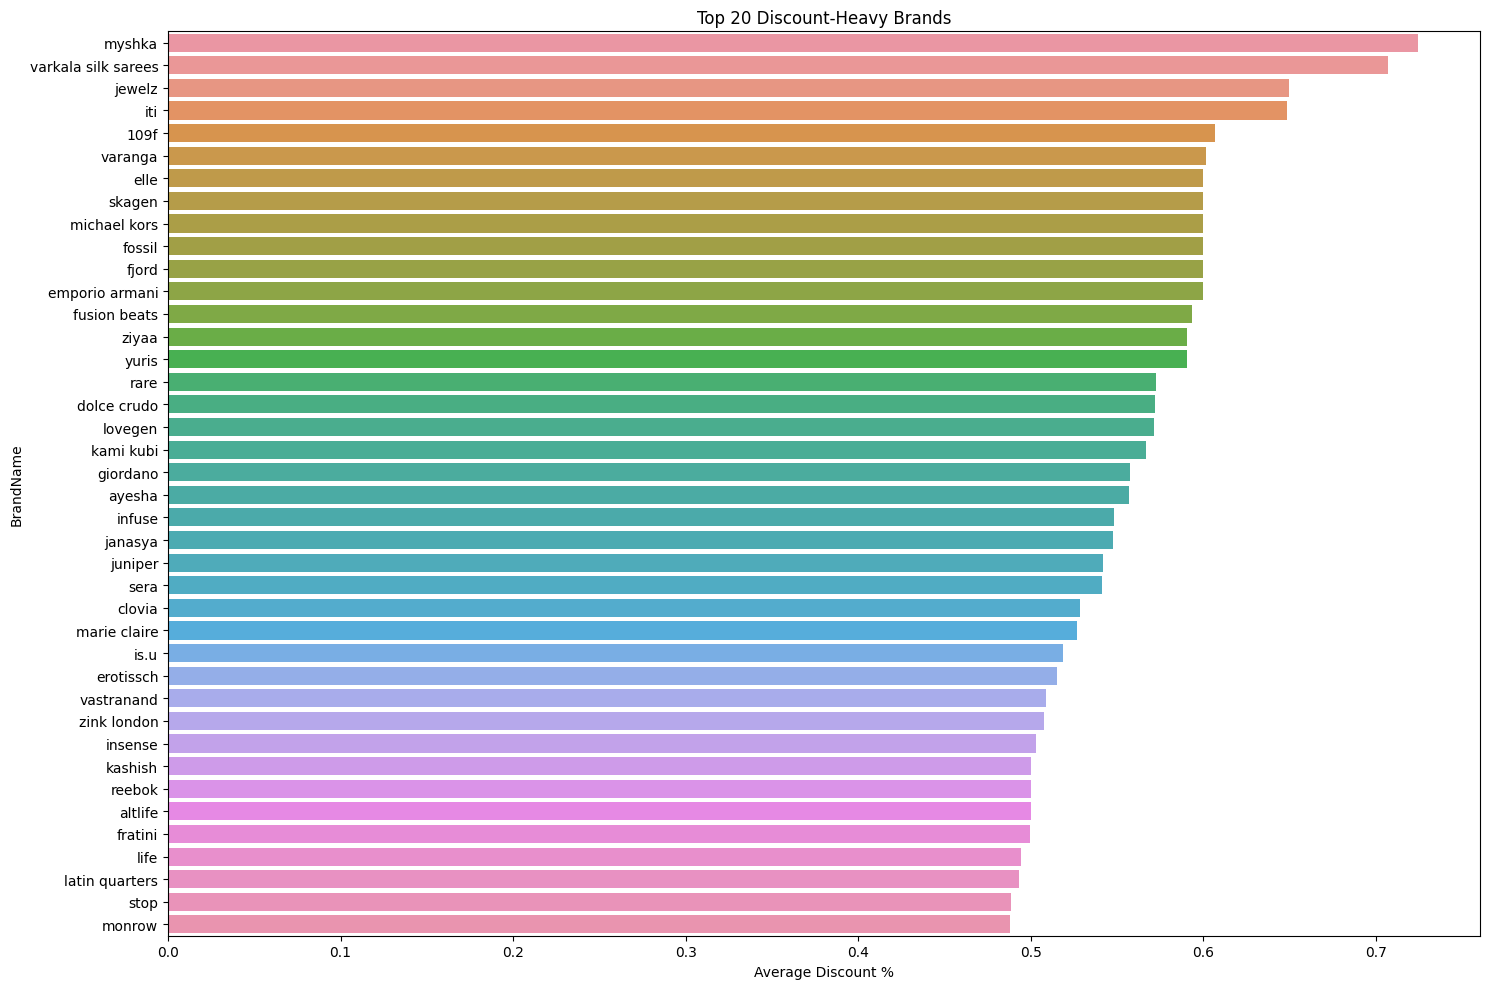

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


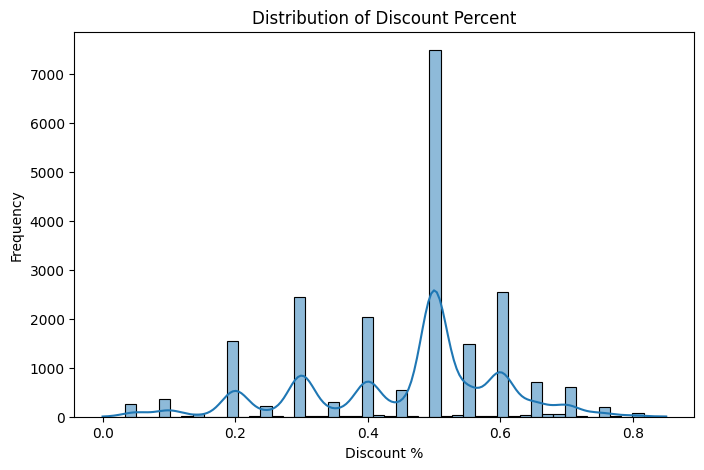

In [24]:
brand_avg_discount = df.groupby("BrandName")["Discount"].mean().sort_values(ascending=False)
top_brands = brand_avg_discount.head(40) 

plt.figure(figsize=(15, 10))
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.xlabel("Average Discount %")
plt.title("Top 20 Discount-Heavy Brands")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.histplot(df["Discount"], bins=50, kde=True)
plt.title("Distribution of Discount Percent")
plt.xlabel("Discount %")
plt.ylabel("Frequency")
plt.show()

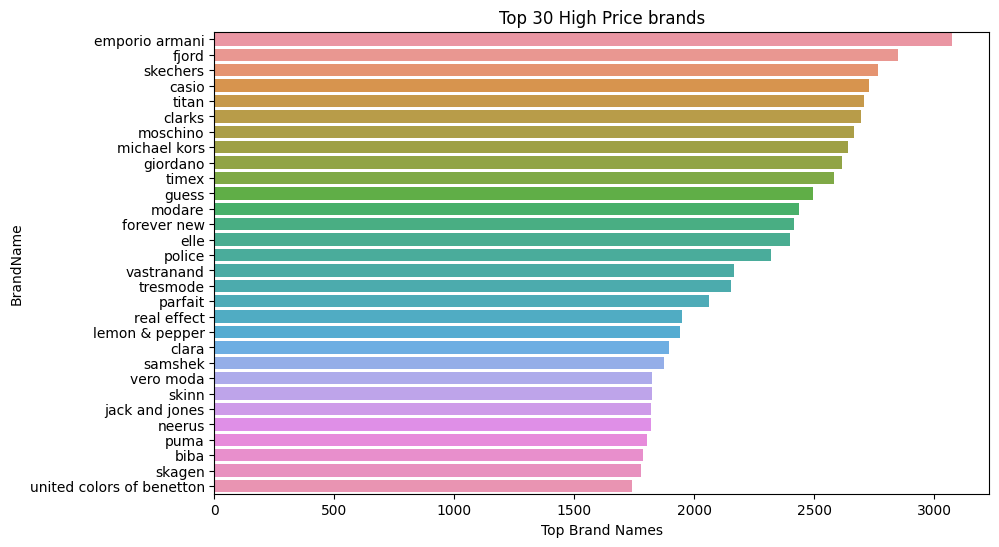

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


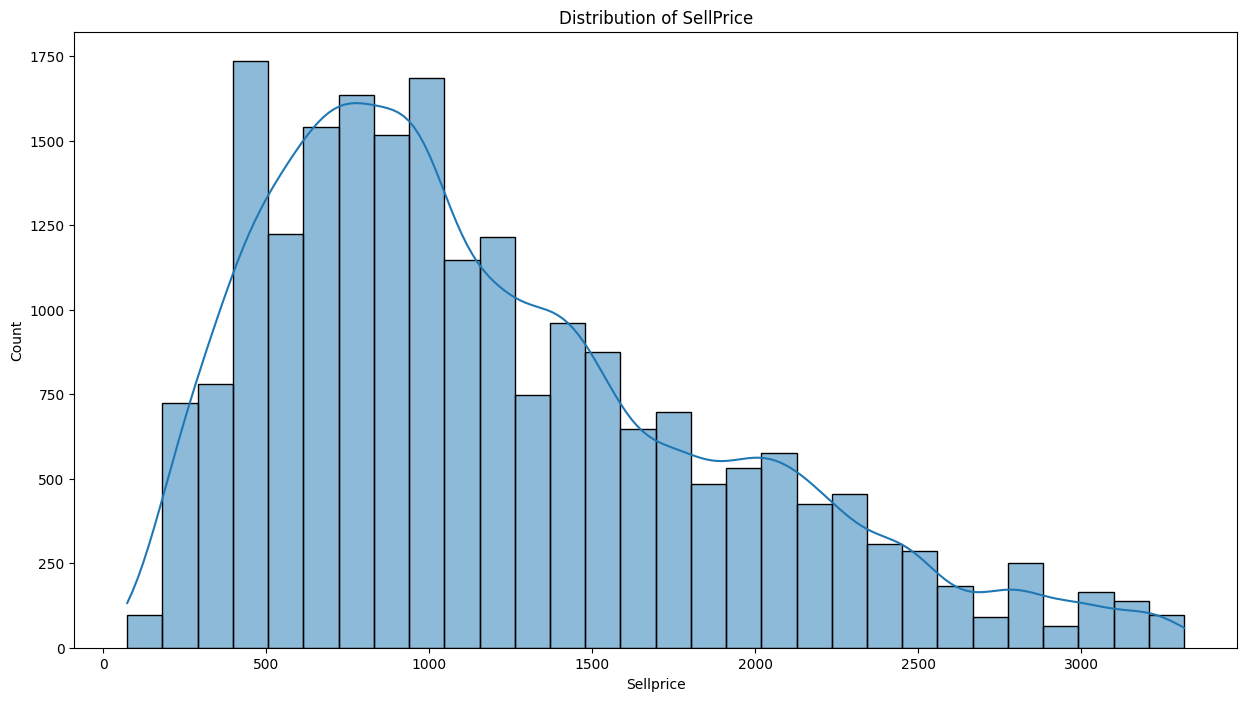

In [25]:
#Brand Average sellprice
Brand_avg_sellprice = df.groupby("BrandName")["SellPrice"].mean().sort_values(ascending=False)
Top_brands = Brand_avg_sellprice.head(30)

plt.figure(figsize=(10,6))
sns.barplot(x=Top_brands.values,y=Top_brands.index)
plt.xlabel("Top Brand Names")
plt.title("Top 30 High Price brands")
plt.show()


plt.figure(figsize=(15,8))
sns.histplot(df["SellPrice"],bins=30,kde=True)
plt.xlabel("Sellprice")
plt.title("Distribution of SellPrice")
plt.show()

In [26]:
df.sample(10)

,BrandName,Details,Sizes,MRP,SellPrice,Discount,Category
17372,kashish,embroidered round neck flared womens kurta - grey,"['Large', 'Medium', 'Small', 'X-Small']",2299.0,1149.0,0.50,Indianwear
519,life,solid cotton round neck womens regular t-shirt...,"['Large', 'Medium', 'Small', 'X-Large', 'X-Sma...",599.0,299.0,0.50,Westernwear
14485,varanga,mandarin collar womens kurta - mustard,"['Medium', 'Small', 'X-Large']",1799.0,809.0,0.55,Indianwear
13929,janasya,womens peach poly silk kurta with palazzo and ...,"['Large', 'Medium', 'Small', 'X-Large', 'X-Sma...",3799.0,2089.0,0.45,Indianwear
18619,global desi,solid viscose rayon round neck womens straight...,['Small'],1599.0,959.0,0.40,Indianwear
6557,and,solid tapered polyester women work wear trouse...,"['26', '28', '30', '32', '34']",2499.0,1624.0,0.35,Westernwear
817,altlife,printed polyester blend regular neck womens t-...,"['Large', 'Medium', 'Small', 'X-Large', 'X-Sma...",599.0,299.0,0.50,Westernwear
115,madame,solid polyester v neck womens top - blush,"['Large', 'Medium', 'Small', 'X-Large', 'XX-La...",1699.0,1189.0,0.30,Westernwear
23356,erotissch,polyester blend womens swim set - silver cloud,"['Large', 'Medium', 'Small', 'X-Large']",2799.0,1819.0,0.35,Lingerie&Nightwear
12920,ziyaa,geometric round neck polyester womens ethnic s...,"['Large', 'Medium', 'Small', 'X-Large', 'XX-La...",3396.0,1358.0,0.60,Indianwear


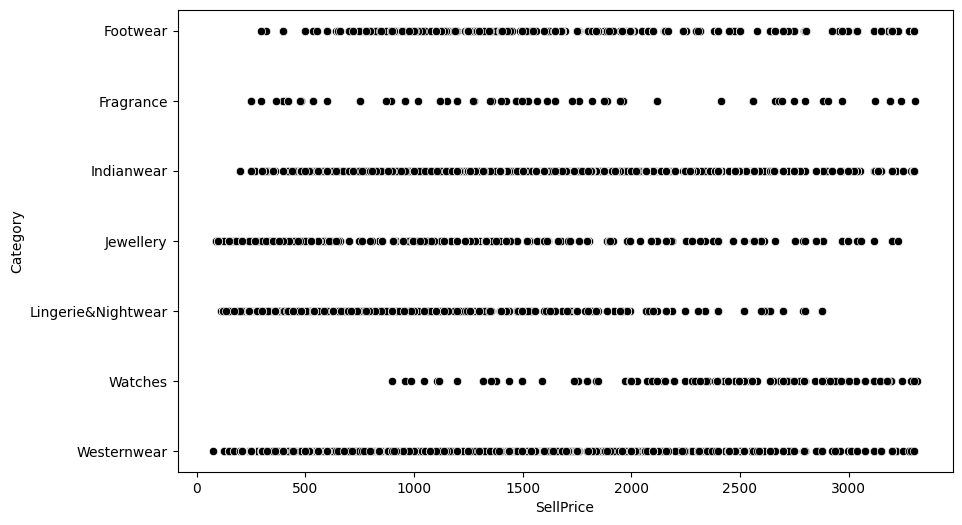

In [27]:
#Relation between Category and MRP
plt.figure(figsize=(10,6))
sns.scatterplot(x = df["SellPrice"],y = df["Category"],color="black")
plt.xlabel("SellPrice")
plt.ylabel("Category")
plt.show()

<Axes: xlabel='Discount', ylabel='Category'>

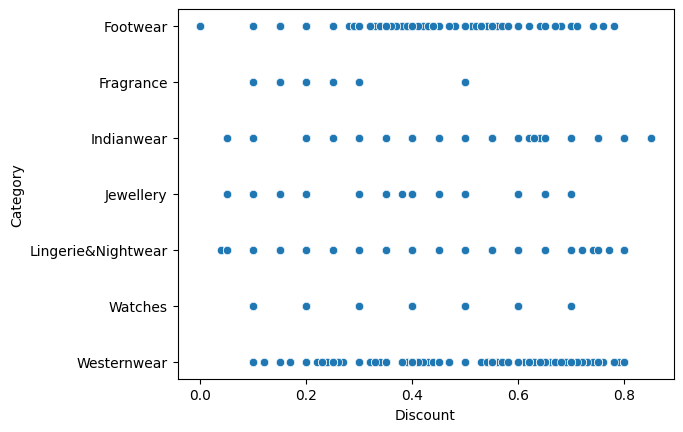

In [28]:
#Discount On CAtegory
sns.scatterplot(x = df["Discount"],y = df["Category"])

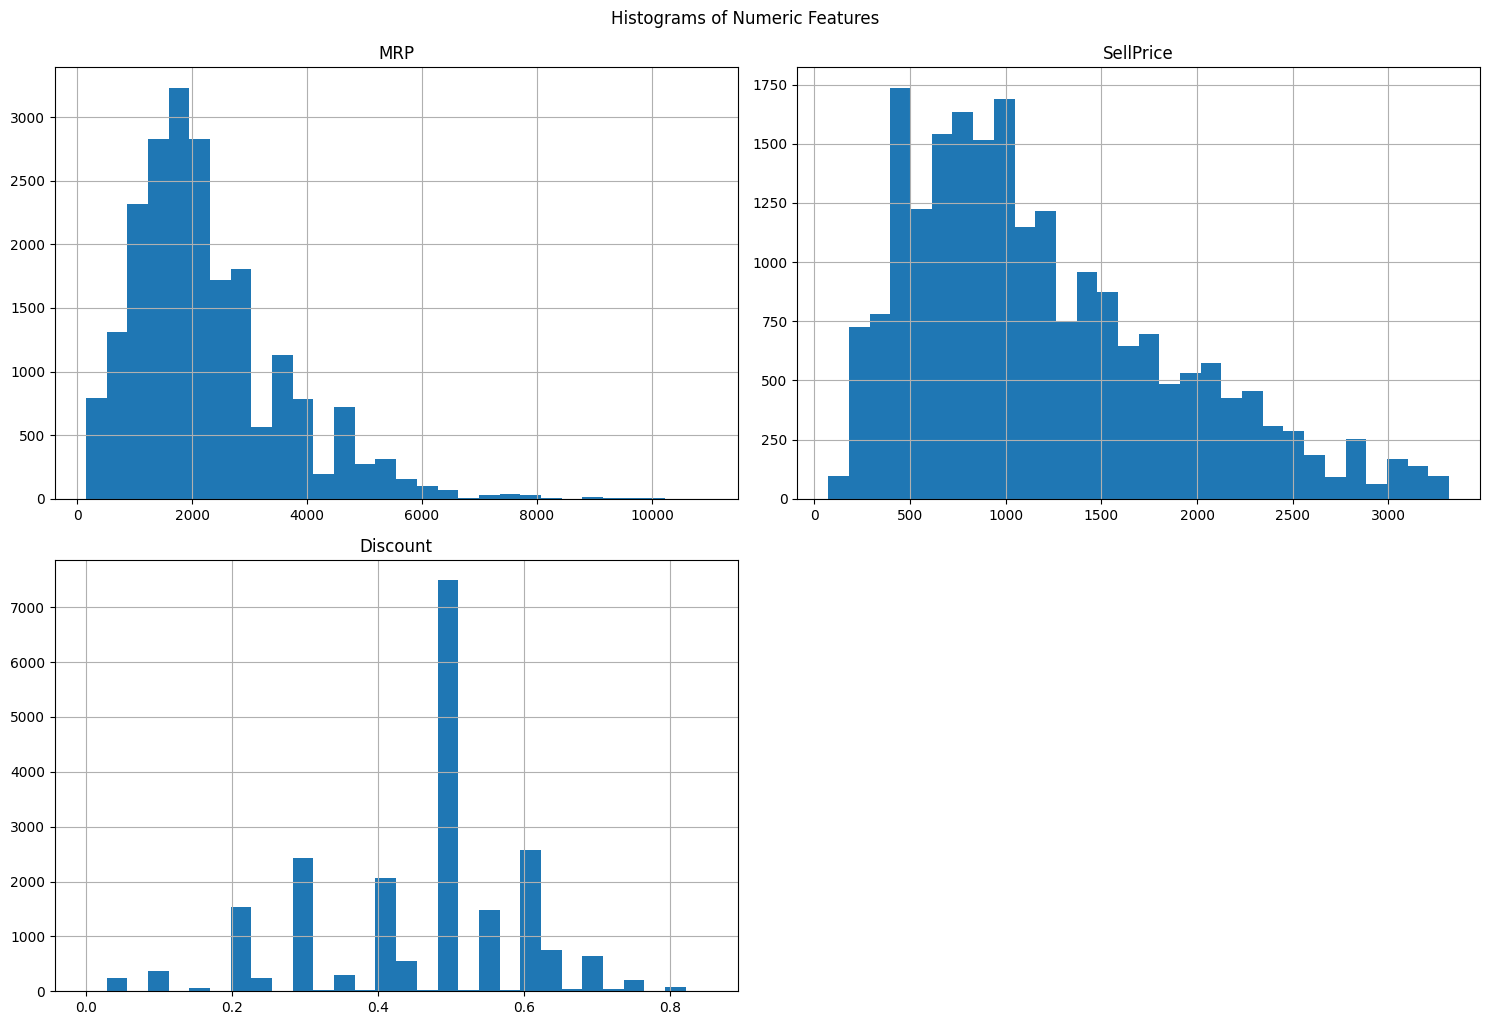

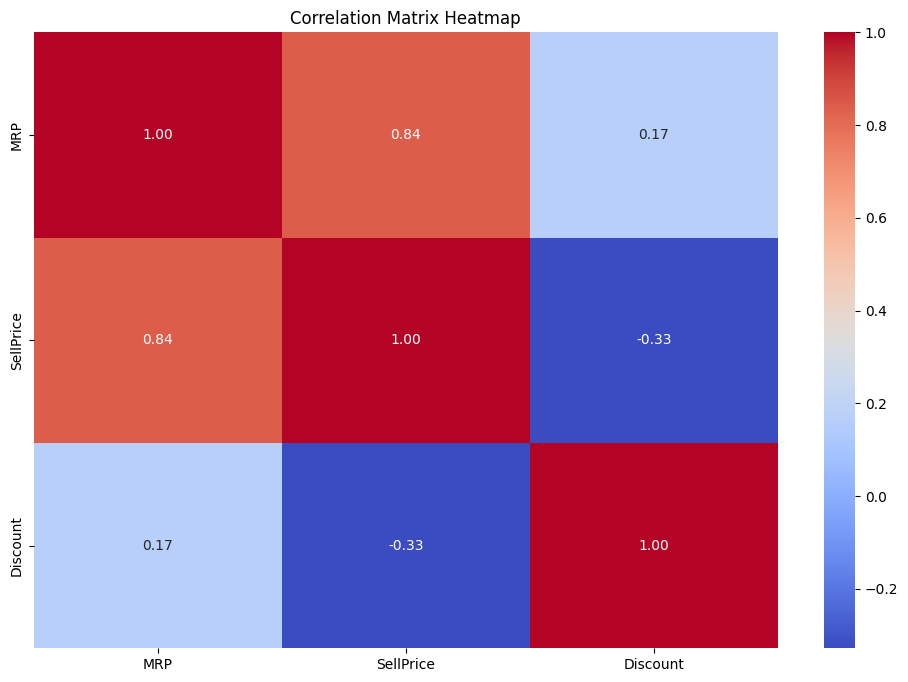

In [29]:
#Histrogram view for numeric featutes
df.select_dtypes(include=['float64', 'int64']).hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.suptitle("Histograms of Numeric Features", y=1.02)
plt.show()

#Correlation matrix 
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


Contingency Table (BrandName vs. Category):
 Category     Footwear  Fragrance  Indianwear  Jewellery  Lingerie&Nightwear  \
BrandName                                                                     
109f                0          0           0          0                   0   
Other               0         21           6          3                   5   
adidas              0          0           0          0                  21   
ajmal               0         14           0          0                   0   
allen solly         0          0           0          0                   0   

Category     Watches  Westernwear  
BrandName                          
109f               0           76  
Other              7           18  
adidas             0          129  
ajmal              0            0  
allen solly        0          214  


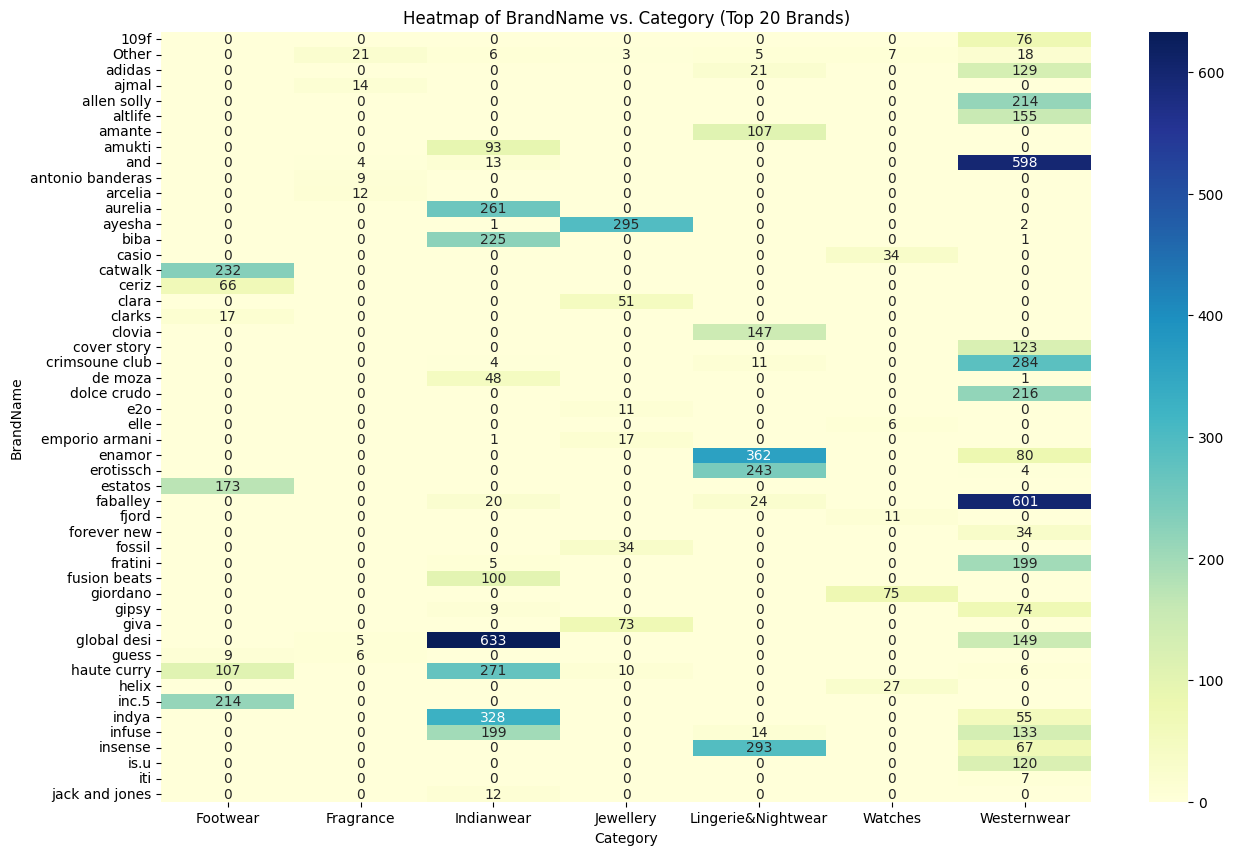


Chi-squared test for BrandName vs. Category:
Chi2 Statistic: 110353.97
P-value: 0.0000
Degrees of Freedom: 660

Since the p-value is less than the significance level (0.05), we reject the null hypothesis.
There is a statistically significant relationship between BrandName and Category.


In [30]:
contingency_table = pd.crosstab(df['BrandName'], df['Category'])

#Display the contingency table head
print("Contingency Table (BrandName vs. Category):\n", contingency_table.head())


#top 40 brands for readability
plt.figure(figsize=(15, 10))
sns.heatmap(contingency_table.head(50), annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap of BrandName vs. Category (Top 20 Brands)')
plt.xlabel('Category')
plt.ylabel('BrandName')
plt.show()

#Perform Chi-squared test
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"\nChi-squared test for BrandName vs. Category:")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of Freedom: {dof}")

#theory for   the p-value
alpha = 0.05
if p < alpha:
    print("\nSince the p-value is less than the significance level (0.05), we reject the null hypothesis.")
    print("There is a statistically significant relationship between BrandName and Category.")
else:
    print("\nSince the p-value is greater than the significance level (0.05), we fail to reject the null hypothesis.")
    print("There is no statistically significant relationship between BrandName and Category.")

In [31]:
# Save the cleaned dataset to a CSV file
df.to_csv("/kaggle/working/Cleaned_FashionDataset.csv", index=False)


##  EDA Summary – Fashion Dataset (Dynamic Pricing Project)

This notebook is part of my project to build a dynamic pricing engine. I performed Exploratory Data Analysis (EDA) on a fashion e-commerce dataset (`FashionDataset.csv`) to understand the structure, clean the data, and get it ready for modeling.

*********

###  Libraries Used:
-->> `pandas` – for handling and cleaning data
-->> `numpy` – for numeric operations
-->> `matplotlib` & `seaborn` – for creating visualizations
-->> `scipy.stats` – for statistical tests like ANOVA and Chi-squared

************

###  Main Steps:
-->> Loaded the dataset and checked structure using `.head()`, `.info()`, `.describe()`
-->> Removed duplicates and unnecessary columns (`Unnamed: 0`)
-->> Cleaned and converted(Some data types) columns: `Sizes`, `MRP`, `SellPrice`, `Discount`,             'Category`, and `BrandName`.
-->> Removed rows with missing `MRP`, and handled outliers in `SellPrice` using IQR
-->> Grouped rare `BrandName` values into `'Other'` for better analysis

**********

###  Problems Faced:
-->> **Inconsistent data types** (like strings with text in numeric columns)
-->> **Outliers** in `SellPrice` were affecting distribution
-->> **Too many unique brands**, so I grouped the less frequent ones
-->> **Reset environment** required re-running preprocessing during work

*********

###  Key Findings:
-->> `MRP` and `Discount` are strong predictors of `SellPrice`
-->> Strong link between `BrandName` and `Category` (confirmed using Chi-squared test)
-->> `Westernwear` is the most dominant category
-->> Brands often specialize in specific categories (e.g., 'ajmal' in Fragrance)

**********

###  Usable for Modeling:
-->> Cleaned `MRP`, `SellPrice`, and `Discount` (numeric and usable)
-->> Simplified `BrandName` and `Category` (less cardinality, more meaningful)
-->> Dataset is ready for feature engineering and training ML models

*****

###  What I’ll Do Next with This Dataset:
Now that EDA is done, the next steps in my project are:

- **Feature Engineering** : I’ll transform the cleaned data into features that machine learning models can understand. For example:
  - Extract useful keywords or attributes from the `Details` column using text processing
  - Convert categorical columns like `BrandName` and `Category` into numeric features (one-hot encoding or label encoding).
  - Handle the `Sizes` column more deeply, possibly by creating size indicators or most common size tags.
  
- **Model Training**: Use the features to train a regression model that predicts `SellPrice` based on inputs like `MRP`, `Discount`, `Brand`, `Category`, and possibly some text-derived features.


This EDA has helped shape a solid foundation for building that pricing engine.

*****

###  Saved Cleaned Dataset
The cleaned dataset was saved as:

```python
df.to_csv("/kaggle/working/Cleaned_FashionDataset.csv", index=False)
